## King’s Super Math Saga experiment

#### Problem statement
Super Math Saga is a fictional mobile game. Like other Saga games, players need to beat levels to progress
through a map. At every level, players are faced with a math question they need to answer correctly to pass
to the next level. The game is Free to Play meaning that players can download and play the game for free
but can optionally buy hints on the levels.

In 2017 we ran an experiment (A/B Test) on the game, offering two different game experiences that we
call A and B, group A being the control group where the experience is kept as is, and group B being
the experiment group that is exposed to the new experience. We set the assignment process to randomly
distribute players among the groups: 80% to group A (control) and 20% to group B (test). The experiment
ran from 2017-05-04 to 2017-05-22.

Your assigment is to analyse and summarise the data provided, to determine which of the experiences makes
Super Math Saga a better game. Send us a short (max 3 pages) report, suitable to present to the head
of studio, with your findings and supporting plots, making recommendations for what the game should
implement and any further analysis you think would be valuable. Markdown or notebook is the preferred
report format.

The assignment table contains players assigned to the A/B test and attributes related to each player.
1. playerid: Unique numeric identifier for each player
2. abtest_group: The group the player was assigned to (A or B)
3. assignment_date: The date when the player was assigned to the test
4. install_date: The date when the player installed the game
5. conversion_date: The date when the player made their first purchase

The activity table contains player activity for each day a player was active.
1. playerid: Unique numeric identifier for each player
2. activity_date: The date of activity
3. purchases: Number of purchases made this day
4. gameends: Number of gamerounds played this day

#### Suggested areas for analysis
1. Which metrics do you consider important to look at in this case? What can you say about them in this
A/B test?
2. What sanity checks can you do to be confident in the validity of the test?
3. Compute the average number of gamerounds per player for each group. Can you confidently state
which group has higher engagement?
4. Do different types of players react differently to the treatment?
5. What type of change to the game do you think was tested here?

In [9]:
#!pip install pandas-gbq
#!pip install db-dtypes

In [2]:
# modules
import pandas as pd
import pandas_gbq
import db_dtypes
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
# gcp to df function
def gcp2df(query):
    project_id = 'king-ds-recruit-candidate-635'
    return pd.read_gbq(query, project_id=project_id, dialect='standard')

query = ('''
    WITH

    activity AS (
    SELECT playerid, SUM(purchases) AS total_purchases, SUM(gameends) as total_gamends
        FROM `king-ds-recruit-candidate-635.abtest.activity` 
        WHERE activity_date BETWEEN "2017-05-04" AND "2017-05-22"
        GROUP BY playerid
    ),

    joinTables AS (
    SELECT ass.*, ac.total_gamends, ac.total_purchases
    FROM `king-ds-recruit-candidate-635.abtest.assignment` AS ass
    LEFT JOIN  activity AS ac
    ON ass.playerid=ac.playerid
    )

    SELECT *
    FROM joinTables
    ''')

df = gcp2df(query)
#df.to_csv("../../../king.csv")

In [19]:
df = pd.read_csv("../../../king.csv", index_col=0)

c:\Users\rmari\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [81]:
df.head()

,playerid,abtest_group,assignment_date,install_date,conversion_date,total_gamends,total_purchases,is_new_player,is_veteran,is_veteran_player
0,51113439,A,2017-05-22,2017-05-22,NaN,11,0,True,True,False
1,51113518,A,2017-05-22,2017-05-22,NaN,7,0,True,True,False
2,51123069,A,2017-05-22,2017-05-22,NaN,10,0,True,True,False
3,51073272,A,2017-05-22,2017-05-22,NaN,4,0,True,True,False
4,51047074,A,2017-05-22,2017-05-22,NaN,15,0,True,True,False


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10331056 entries, 0 to 10331055
Data columns (total 11 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   playerid           int64 
 1   abtest_group       object
 2   assignment_date    object
 3   install_date       object
 4   conversion_date    object
 5   total_gamends      int64 
 6   total_purchases    int64 
 7   is_new_player      bool  
 8   is_veteran         bool  
 9   is_veteran_player  bool  
 10  player_type        object
dtypes: bool(3), int64(3), object(5)
memory usage: 738.9+ MB


In [89]:
df["install_date"].min()

'2016-01-01'

In [85]:
df[["assignment_date", "install_date", "conversion_date"]] = pd.to_datetime(df[["assignment_date", "install_date", "conversion_date"]],  format="%y-%m-%d")

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

#### 1. Which metrics do you consider important to look at in this case? What can you say about them in this A/B test?

Engagement metric:
1. Average gamerounds played per user
2. New players' retention rate

Monetization metrics:
1. Average revenue per user
2. Average revenue per paying user
3. Time to first purchase
4. Share of paying users


In [34]:
df[["abtest_group", "total_gamends", "total_purchases"]].groupby(by="abtest_group").agg(np.mean)


,total_gamends,total_purchases
abtest_group,,
A,158.563439,0.366211
B,155.490497,0.39257


#### 2. What sanity checks can you do to be confident in the validity of the test?

In [30]:
# Do the control (A) and test (B) groups contain 80 and 20 percent of the players respectively?
df.abtest_group.value_counts(normalize=True)

A    0.800074
B    0.199926
Name: abtest_group, dtype: float64

In [26]:
# Are there duplicated playerids?
df["playerid"].duplicated().any()

False

In [67]:
# Checking invariants: Is the percentage of new players the same in both groups?
df["is_new_player"] = df["install_date"] >= "2017-05-04"
df.groupby("abtest_group")["is_new_player"].mean()

abtest_group
A    0.180213
B    0.180765
Name: is_new_player, dtype: float64

In [73]:
# Checking invariants: Is the percentage of veteran players the same in both groups?
df["is_veteran_player"] = df["install_date"] <= "2016-05-04"
df.groupby("abtest_group")["is_veteran_player"].mean()

abtest_group
A    0.110319
B    0.109981
Name: is_veteran_player, dtype: float64

#### 4. Do different types of players react differently to the treatment?

In [90]:
conditions = [
    (df["install_date"] >= "2017-05-04"),
    (df["install_date"] < "2017-05-04") & (df["install_date"] <= "2016-06-06"),
    (df["install_date"] < "2016-06-01")
    ]

values = ["newbie", "experienced", "OG"]

df["player_type"] = np.select(conditions, values)
df[["abtest_group", "player_type", "total_gamends", "total_purchases"]].groupby(by=["abtest_group", 
                                                                                    "player_type"]).agg(np.mean)


total_gamends  total_purchases
abtest_group player_type                                
A            0               178.521335         0.412118
             experienced     185.627311         0.430645
             newbie           62.127698         0.142656
B            0               175.131749         0.445606
             experienced     181.963018         0.451266
             newbie           61.070621         0.147731

In [57]:
df[["abtest_group", "is_new_player", "total_gamends", "total_purchases"]].groupby(by=["abtest_group", "is_new_player"]).agg(np.mean)

total_gamends  total_purchases
abtest_group is_new_player                                
A            False             179.762862         0.415355
             True               62.127698         0.142656
B            False             176.324380         0.446595
             True               61.070621         0.147731

In [71]:
df[["abtest_group", "is_veteran_player", "total_gamends", "total_purchases"]].groupby(by=["abtest_group", "is_veteran_player"]).agg(np.mean)

total_gamends  total_purchases
abtest_group is_veteran_player                                
A            False                 155.188295         0.358111
             True                  185.782726         0.431536
B            False                 152.221610         0.386544
             True                  181.943881         0.441341

<function matplotlib.pyplot.show(close=None, block=None)>

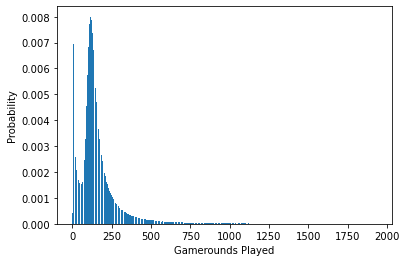

In [41]:
pmfA = A.total_gamends.value_counts(normalize=True)
plt.bar(pmfA.index, pmfA)
plt.ylabel("Probability")
plt.xlabel("Gamerounds Played")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

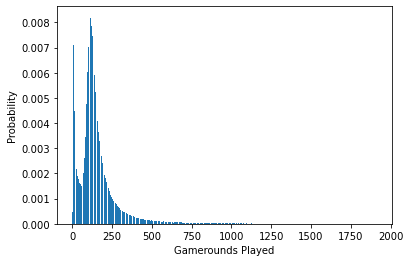

In [42]:
pmfB = B.total_gamends.value_counts(normalize=True)
plt.bar(pmfB.index, pmfB)
plt.ylabel("Probability")
plt.xlabel("Gamerounds Played")
plt.show